In [1]:
### Imports
import numpy as np
import matplotlib.pyplot as plt
from numba import njit  
import sys
from numpy.polynomial.legendre import leggauss
from scipy.sparse import diags
from scipy.sparse.linalg import bicgstab
from numpy.linalg import norm
from matplotlib import cm
from matplotlib.colors import Normalize
from functions import * 
from integrators import *
from drop_simulation import DropSimulation

# General Arguments

# Explicit Solver

In [2]:
simulator_explicit = DropSimulation(N=32, DT=0.0001, SIMULATION_TIME=1, method='explicit', integration_method='gauss')
results_explicit = simulator_explicit.run_simulation()

/var/folders/nw/4ytlqsqs3s1bzf4_09kycb_40000gn/T/ipykernel_42656/327097144.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Time (s)')


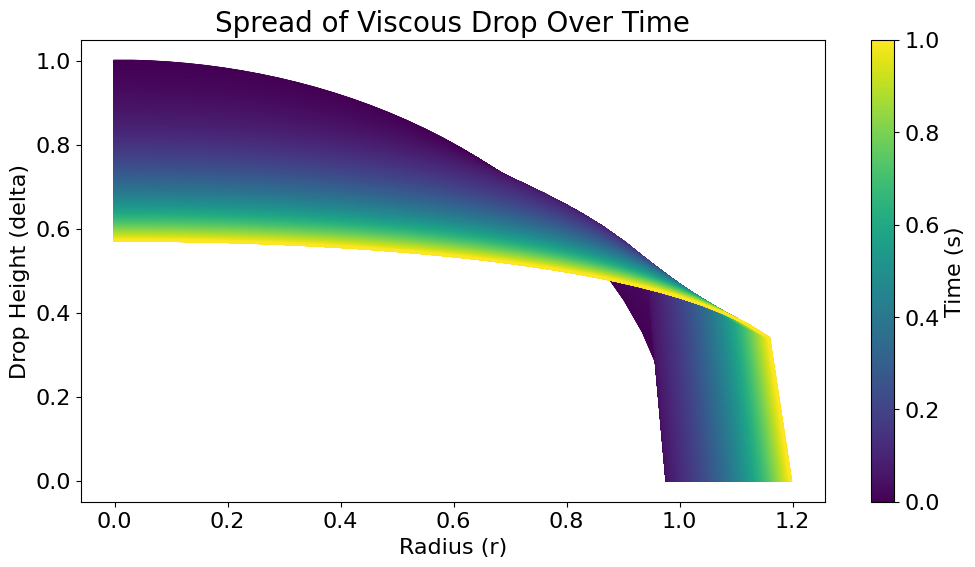

In [3]:
# Configuración de la visualización
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=simulator_explicit.SIMULATION_TIME)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Crear gráficos
plt.figure(figsize=(12, 6))
step = int(len(results_explicit['times']) / len(results_explicit['times']))  # Asegúrate de que esta línea tenga sentido

for i in range(0, len(results_explicit['deltas']), step):
    plt.plot(results_explicit['xi'] * results_explicit['bs'][i], results_explicit['deltas'][i], color=cmap(norm(results_explicit['times'][i])))

plt.colorbar(sm, label='Time (s)')
plt.xlabel('Radius (r)')
plt.ylabel('Drop Height (delta)')
plt.title('Spread of Viscous Drop Over Time')
plt.savefig('ProfileImplicit_' + str(simulator_explicit.N) + '.svg', format='svg', dpi=1200)
plt.show()

# Implicit Solver

In [ ]:
simulator_implicit = DropSimulation(N=32, DT=0.001, SIMULATION_TIME=100, method='implicit', integration_method='gauss')
results_implicit = simulator_implicit.run_simulation()

In [ ]:
# Configuración de la visualización
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=simulator_implicit.SIMULATION_TIME)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Crear gráficos
plt.figure(figsize=(12, 6))
step = int(len(results_implicit['times']) / len(results_implicit['times']))  # Asegúrate de que esta línea tenga sentido

for i in range(0, len(results_implicit['deltas']), step):
    plt.plot(results_implicit['xi'] * results_implicit['bs'][i], results_implicit['deltas'][i], color=cmap(norm(results_implicit['times'][i])))

plt.colorbar(sm, label='Time (s)')
plt.xlabel('Radius (r)')
plt.ylabel('Drop Height (delta)')
plt.title('Spread of Viscous Drop Over Time')
plt.savefig('ProfileImplicit_' + str(simulator_implicit.N) + '.svg', format='svg', dpi=1200)
plt.show()

In [ ]:
# Explicit 
from integrators import trapezoidal_integral

def update_profile(delta_in, b, xi, dt_in):
    delta_new = np.zeros(len(delta_in))
    delta = delta_in
    RHS = delta_in
    RHS[0] = 0
    RHS[-1] = 0
    dt = dt_in
    delta[0] = delta[1]

    A = create_matrix(delta, b, xi, dt)
    A_reduced = np.array(A[1:-2, 1:-2], dtype=np.float64)
    spectral_rad = spectral_radius(A_reduced)
    #print("Spectral rad:" + str(spectral_rad))
    while spectral_rad >= 1:
        dt = 0.9 * dt
        A = create_matrix(delta, b, xi, dt)
        A_reduced = np.array(A[1:-2, 1:-2], dtype=np.float64)
        spectral_rad = spectral_radius(A_reduced)     

    #print(dt)
    
    # solve for delta_new using time step
    delta_new = step(delta, b, xi, dt)
    return delta_new, dt

def step(delta, b, xi, dt):
    delta_new = np.zeros_like(delta)
    for i in range(1, N-1):
        r_factor = delta[i]**3 / b**2
        dxi = xi[i+1] - xi[i]
        derivative = (delta[i-1] - 2 * delta[i] + delta[i+1]) / dxi**2
        convective = 3 * delta[i]**2 /b**2 * ((delta[i+1] - delta[i-1]) / (2 * dxi))**2
        delta_new[i] = delta[i] + DT * G / (3 * NU) * (r_factor * derivative + convective)
    delta_new[0] = delta_new[1]
    delta_new[-1] = 0
    return delta_new

def create_matrix(u, radius, xi, dt):
    # Creates Matrix A for Explicit Solver u^{n+1} = A*RHS^{n}
    N = len(xi)
    dxi = xi[1] - xi[0]
    Out = np.zeros((N,N))
    # Inner Points

    k = G*dt/3/NU
    
    for i in range(1, N-1):
        a = u[i]**3 / radius**2
        b = 3*u[i]**2 / radius**2

        # working but iffy
        #A = a*k*(1/dxi**2 - 1/(2*xi[i]*dxi)) - b*k/2/dxi 
        #B = (1 - 2*a*k/dxi**2)
        #C = a*k*(1/dxi**2 + 1/(2*xi[i]*dxi)) + b*k/2/dxi 
        
        # not working
        A = a*k*(1/dxi**2 - 1/(2*xi[i]*dxi)) + k*b/4/dxi**2*(u[i-1] - u[i+1])
        B = (1 - 2*a*k/dxi**2)
        C = a*k*(1/dxi**2 + 1/(2*xi[i]*dxi)) + k*b/4/dxi**2*(u[i+1] - u[i-1])

        Out[i,i-1] = A
        Out[i,i] = B
        Out[i,i+1] = C

    # Boundary Points
    Out[N-1,N-1] = 1
    Out[0,0] = 1
    Out[0,1] = -1

    #print(Out)
    return Out

def spectral_radius(A_reduced):
    eig_values = np.linalg.eigvals(A_reduced)
    rho = np.max(np.abs(eig_values))
    return rho

def main_simulation():
    dt = DT
    xi = np.linspace(0, 1, N)
    delta = np.sqrt(1 - xi**2)
    delta[0] = delta[1]
    b = 1.0
    V0 = trapezoidal_integral(b * xi, delta)

    volumes = []
    bs = []
    times = []
    deltas = []
    times = []
    
    time_val = 0

    while time_val < SIMULATION_TIME:
    #for abcdefg in range(1):
        delta_new, dt = update_profile(delta, b, xi, DT)
    
        V_new = trapezoidal_integral(b * xi, delta_new)
        if V_new > 0:
            b *= (V0 / V_new)**(1/3)
            
        delta = delta_new
        volumes.append(V_new)
        bs.append(b)
        times.append(time_val)
        deltas.append(delta.copy())

        time_val += dt

    return xi, times, bs, volumes, deltas

In [ ]:
# Run Explicit Solver
N = 64 # Number of divisions in the radial direction
DT = 0.001 # Baseline Time step (s)
SIMULATION_TIME = 10  # Total time for simulation (s)
xi, times, bs, volumes, deltas = main_simulation()

In [ ]:
# Implicit code 

from integrators import trapezoidal_integral

def create_matrix(u, d, xi, dt):
    # Creates Matrix A for Implicit Solver A*u^{n+1} = RHS^{n}
    k = G*dt/3/NU
    N = len(xi)
    dxi = xi[1] - xi[0]
    Out = np.zeros((N,N))
    # Inner Points
    for i in range(1, N-1):
        #print(b)
        a = u[i]**3 / d**2
        b = 3*u[i]**2 / d**2
        
        A = a*k*(1/dxi**2 - 1/(2*xi[i]*dxi)) + k*b/4/dxi**2*(u[i-1] - u[i+1])
        B = (-1 - 2*a*k/dxi**2)
        C = a*k*(1/dxi**2 + 1/(2*xi[i]*dxi)) + k*b/4/dxi**2*(u[i+1] - u[i-1])
        
        Out[i,i-1] = A
        Out[i,i] = B
        Out[i,i+1] = C

    # Boundary Points
    Out[N-1,N-1] = 1
    Out[0,0] = 1
    Out[0,1] = -1

    #print(Out)
    return Out    

def update_profile(delta, b, xi, V0, dt):
    delta_new = delta
    err = 1

    RHS = np.zeros(N)
    RHS[1:-2] = -delta[1:-2]

    # Converge on solution
    # Guess delta_new = delta
    delta_new = delta
    err = 1
    while err > 1E-10:
        # solve for delta_new through matrix inversion
        A = create_matrix(delta_new, b, xi, dt)
        delta_new_2 = np.linalg.solve(A, RHS)
        err = np.abs(np.max(delta_new_2 - delta_new))
        delta_new = delta_new_2

    return delta_new

def volume_shooting(b, xi, delta_new, V0):
    b_range = np.array((0.5*b,3*b))
    err = 1
    while err > 1E-14:
    #for i in range(20):
        b_guess = np.mean(b_range)
        V_new = trapezoidal_integral(b_guess*xi,delta_new)

        if V_new > V0:
            b_range[1] = b_guess
        elif V_new < V0:
            b_range[0] = b_guess
        else:
            break
        err = np.abs(V_new - V0)

    return b_guess

def main_simulation():
    xi = np.linspace(0, 1, N)
    delta = np.sqrt(1 - xi**2)
    b = 1
    V0 = trapezoidal_integral(b * xi, delta)

    volumes = []
    bs = []
    times = []
    deltas = []

    time = 0
    dt = DT
    while time < SIMULATION_TIME:
    #for time in np.arange(0, SIMULATION_TIME, DT):
        delta_new = update_profile(delta, b, xi, V0, dt)
   
        b = volume_shooting(b, xi, delta_new, V0)
        V_new = trapezoidal_integral(b * xi, delta_new)

        time += dt
        
        delta = delta_new
        volumes.append(V_new)
        bs.append(b)
        times.append(time)
        deltas.append(delta.copy())
        dt *= 1.1
        

    return xi, times, bs, volumes, deltas

In [ ]:
# Run Implicit Solver
N = 1024 # Number of divisions in the radial direction
DT = 0.001 # Baseline Time step (s)
SIMULATION_TIME = 1000  # Total time for simulation (s)
xi, times, bs, volumes, deltas = main_simulation()

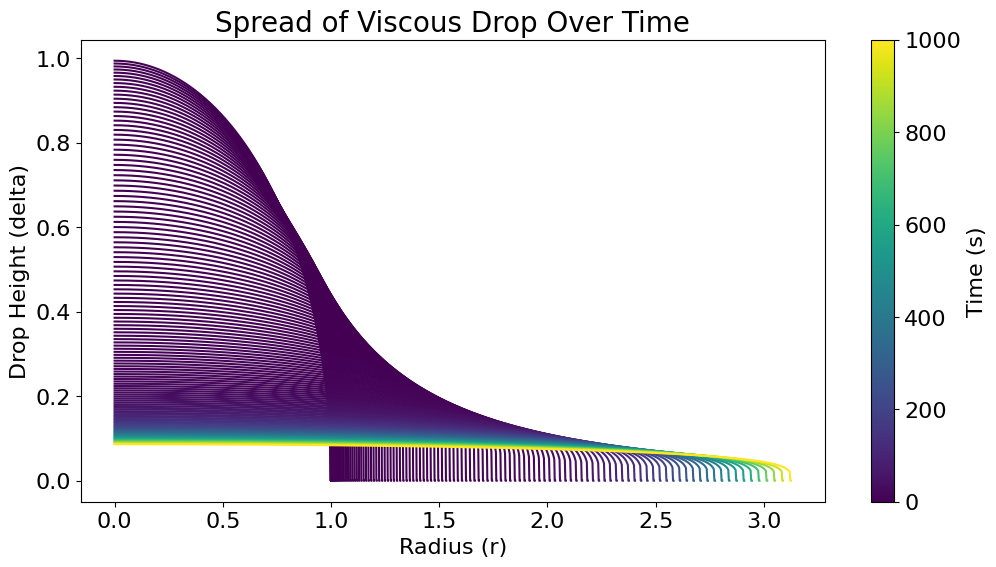

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# Configuración inicial para la coloración
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=SIMULATION_TIME)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(12, 6))

step = int(len(times) / len(times)) 

for i in range(0, len(deltas), step):
    plt.plot(xi * bs[i], deltas[i], color=cmap(norm(times[i])))

plt.colorbar(sm, label='Time (s)',ax=plt.gca())
plt.xlabel('Radius (r)')
plt.ylabel('Drop Height (delta)')
plt.title('Spread of Viscous Drop Over Time')
plt.savefig('ProfileImplicit_'+str(N)+'.svg', format='svg', dpi=1200)
plt.show()



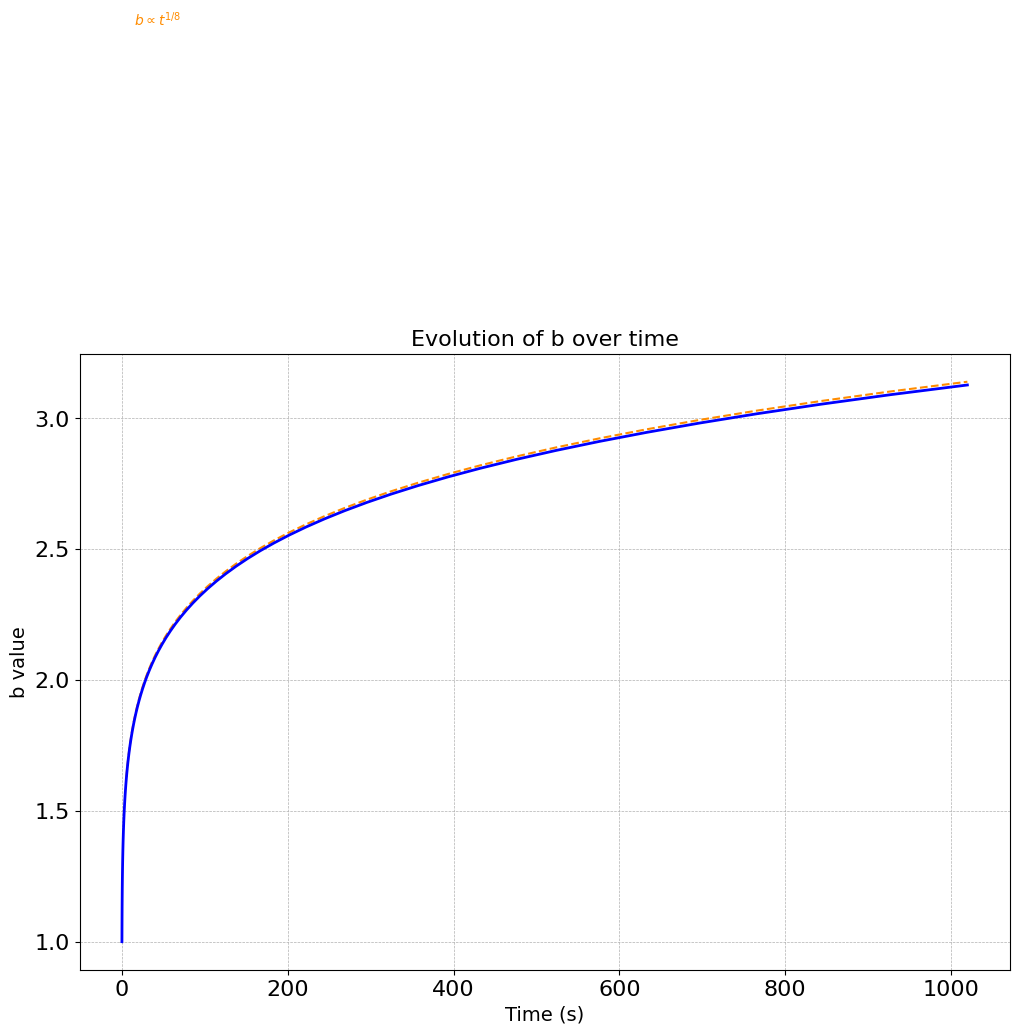

In [ ]:
# Convert lists to arrays for easier handling
times = np.array(results['times'])
bs = np.array(results['bs'])

# Filter data starting from a specific time
start_index = np.where(times > 5)[0][0]  # Start analysis from t=5 seconds

# Set up the plot
plt.figure(figsize=(12, 8))

# Theoretical law b ∝ t^{1/8}
plt.plot(times[start_index:], 1.32 * times[start_index:]**(1/8), label=r'$C \cdot t^{1/8}$', linestyle='--', color='darkorange')
plt.text(times[-1] / 2, 1.32 * times[-1]**(1/8) + 0.1, r'$b \propto t^{1/8}$', color='darkorange')

# Simulation data
plt.plot(times, bs, label='b over time', color='blue', linewidth=2)

# Chart decorations
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('b value', fontsize=14)
plt.title('Evolution of b over time', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.show()


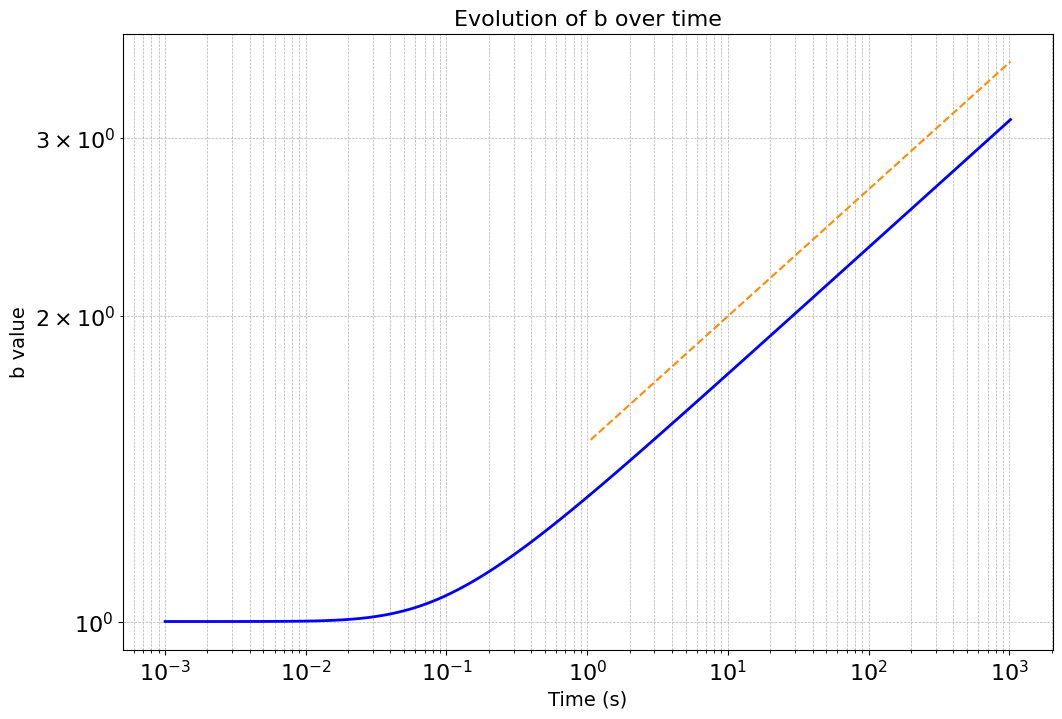

In [ ]:
times = np.array(times)  
bs = np.array(bs)

start_index = np.where(times > 1)[0][0]  
plt.figure(figsize=(12, 8))

plt.plot(times[start_index:],  1.5*times[start_index:]**(1/8) , label=r'$C \cdot t^{1/8}$', linestyle='--', color='darkorange')
#plt.text(1,4.5, r'$b \propto t^{1/8}$',color = 'darkorange' )

plt.plot(times, bs, label='b over time', color='blue', linewidth=2)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('b value', fontsize=14)
plt.title('Evolution of b over time', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
#plt.savefig('b_Implicit_'+str(N)+'.png')
#plt.savefig('b_Implicit_'+str(N)+'.svg', format='svg', dpi=1200)

plt.show()

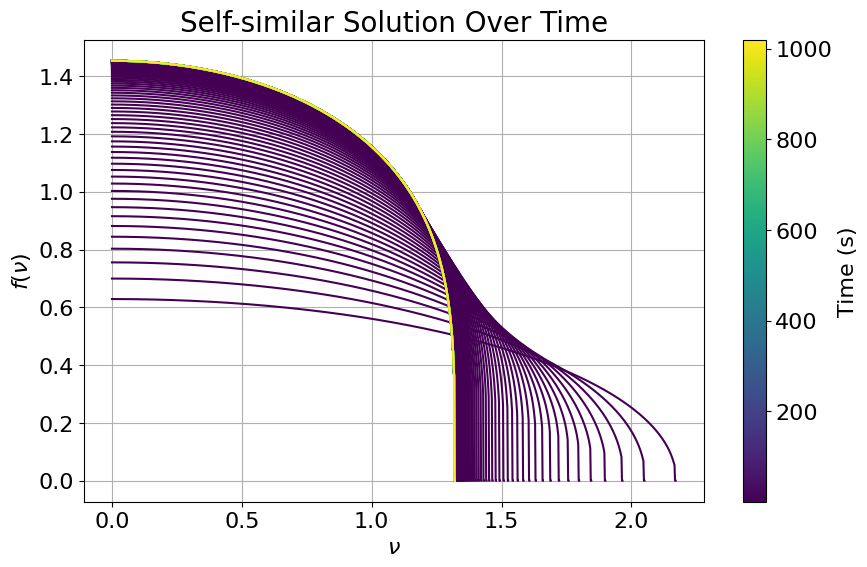

In [ ]:
# Constants for scaling
C = 1  # Adjust as per the problem's requirement for correct scaling
G = 9.81  # Gravitational constant
 
xi = np.linspace(0, 1, N)
delta = np.sqrt(1 - xi**2)
b = 1.0
V0 = trapezoidal_integral(b * xi, delta)

#xi, times, bs, volumes, deltas = main_simulation()
plot_similarity_solution(xi, times, bs, deltas, V0)

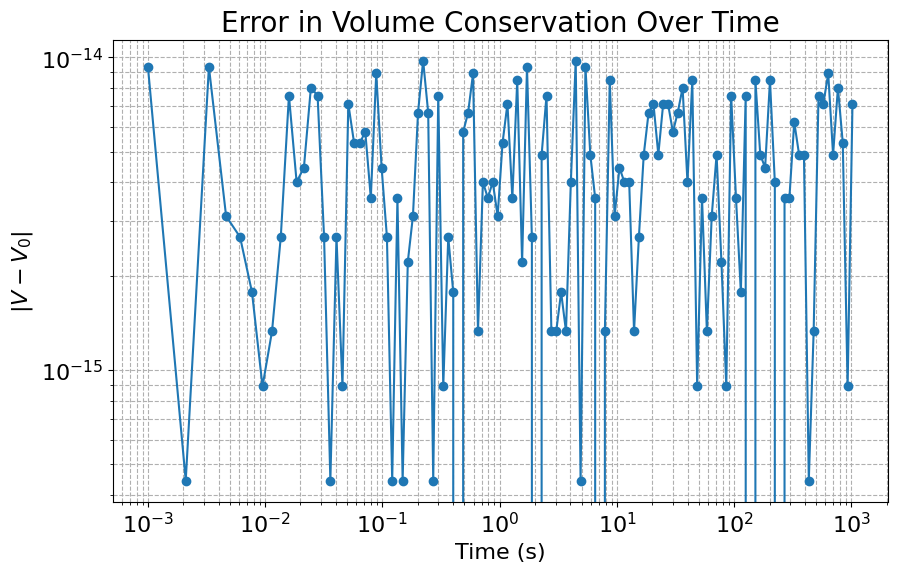

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate absolute difference from the initial volume
volume_errors = np.abs(np.array(volumes) - V0)

# Plotting the error over time on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.loglog(times, volume_errors, marker='o', linestyle='-')
plt.xlabel('Time (s)')
plt.ylabel(r'$|V-V_0|$')
plt.title('Error in Volume Conservation Over Time')
plt.grid(True, which="both", ls="--")
#plt.savefig('Volume_ERR_Implicit_'+str(N)+'.png')
#plt.savefig('Volume_ERR_Implicit_'+str(N)+'.svg', format='svg', dpi=1200)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate absolute difference from the initial volume
volume_errors = np.abs(np.array(volumes) - V0)

# Plotting the error over time on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.loglog(times, volume_errors, marker='o', linestyle='-')
plt.xlabel('Time (s)')
plt.ylabel(r'$|V-V_0|$')
plt.title('Error in Volume Conservation Over Time')
plt.grid(True, which="both", ls="--")
plt.show()